<a href="https://colab.research.google.com/github/melvinsackaria/DeepLearning/blob/main/Stock_Price_Prediction_And_Forecasting_Using_Stacked_LSTM_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Stacked LSTM** architecture can be defined as an LSTM model comprised of multiple LSTM layers. An LSTM layer above provides a sequence output rather than a single value output to the LSTM layer below. 
Specifically, one output per input time step, rather than one output time step for all input time steps.

In [1]:
### Data Collection
import pandas_datareader as pdr
key="f5be53ecb92a8b84c43cacd80c460b3aaabf577a"#https://api.tiingo.com/documentation/general/overview

In [2]:
df = pdr.get_data_tiingo('AAPL', api_key=key)

/usr/local/lib/python3.7/dist-packages/pandas_datareader/tiingo.py:234: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  return pd.concat(dfs, self._concat_axis)


In [3]:
df.to_csv('AAPL.csv')

In [4]:
import pandas as pd
df=pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2017-05-02 00:00:00+00:00,147.51,148.09,146.84,147.54,39752670,34.812924,34.949807,34.654802,34.820004,159010680,0.0,1.0
1,AAPL,2017-05-03 00:00:00+00:00,147.06,147.49,144.27,145.59,45142806,34.706723,34.808204,34.048272,34.359797,180571224,0.0,1.0
2,AAPL,2017-05-04 00:00:00+00:00,146.53,147.14,145.81,146.52,23275690,34.581641,34.725603,34.411718,34.579281,93102760,0.0,1.0
3,AAPL,2017-05-05 00:00:00+00:00,148.96,148.98,146.76,146.76,26787359,35.155130,35.159850,34.635922,34.635922,107149436,0.0,1.0
4,AAPL,2017-05-08 00:00:00+00:00,153.01,153.70,149.03,149.03,48339210,36.110945,36.273788,35.171650,35.171650,193356840,0.0,1.0


In [ ]:
df.tail()

In [5]:
df1=df.reset_index()['close']

In [6]:
df1

0       147.51
1       147.06
2       146.53
3       148.96
4       153.01
         ...  
1254    162.88
1255    156.80
1256    156.57
1257    163.64
1258    157.65
Name: close, Length: 1259, dtype: float64

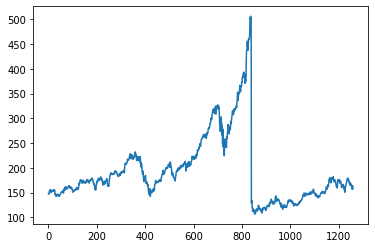

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [8]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
import numpy as np

In [9]:
df1

0       147.51
1       147.06
2       146.53
3       148.96
4       153.01
         ...  
1254    162.88
1255    156.80
1256    156.57
1257    163.64
1258    157.65
Name: close, Length: 1259, dtype: float64

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [11]:
print(df1)

[[0.101866  ]
 [0.10073889]
 [0.0994114 ]
 ...
 [0.12455855]
 [0.14226675]
 [0.12726362]]


For time series data its not a good idea to use randomseed or crossvalidation as previous days data has influence in today value.


In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(818, 441)

In [15]:
#train_data

**Data Preprocessing**
TimeStep - if we want to predict next day output , how many previous days values you have to consider.

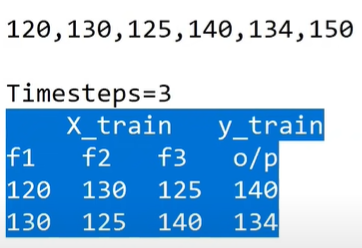

In [16]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [17]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [18]:
print(X_train.shape), print(y_train.shape)

(717, 100)
(717,)


(None, None)

In [19]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [20]:
# Above shape is 2D. we have to reshape input (into a 3D) to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [21]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 9s 304ms/step - loss: 0.0298 - val_loss: 0.0017
Epoch 2/100
12/12 [==============================] - 2s 185ms/step - loss: 0.0063 - val_loss: 0.0073
Epoch 3/100
12/12 [==============================] - 2s 185ms/step - loss: 0.0027 - val_loss: 6.6968e-04
Epoch 4/100
12/12 [==============================] - 2s 184ms/step - loss: 0.0014 - val_loss: 3.0261e-04
Epoch 5/100
12/12 [==============================] - 2s 182ms/step - loss: 0.0010 - val_loss: 2.6972e-04
Epoch 6/100
12/12 [==============================] - 2s 186ms/step - loss: 9.8853e-04 - val_loss: 2.6499e-04
Epoch 7/100
12/12 [==============================] - 2s 184ms/step - loss: 9.5892e-04 - val_loss: 2.6716e-04
Epoch 8/100
12/12 [==============================] - 2s 182ms/step - loss: 9.7486e-04 - val_loss: 3.2454e-04
Epoch 9/100
12/12 [==============================] - 3s 228ms/step - loss: 8.7644e-04 - val_loss: 2.5421e-04
Epoch 10/100
12/12 [===========================

In [26]:
import tensorflow as tf

In [27]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [28]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [29]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

221.06929359362036

In [30]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

147.81654679700154

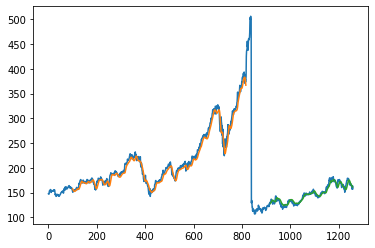

In [31]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

orange - train data , green - predicted

In [32]:
len(test_data)

441

Suppose last day in my dataset is 22 may, to predict for 23rd may i have to take previous 100 days data . 441-100

In [33]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [34]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [35]:
temp_input

[0.1611521603005635,
 0.17092047589229803,
 0.16961803381340007,
 0.18186599874765175,
 0.17257357545397617,
 0.16904195366311836,
 0.1814902943018159,
 0.1638572323105823,
 0.16105197244834057,
 0.1575704445835942,
 0.1656856606136506,
 0.1723231058234188,
 0.17392611145898557,
 0.18407013149655604,
 0.18146524733876013,
 0.1816906700062617,
 0.1787351283656856,
 0.17715716969317463,
 0.18827802128991855,
 0.182492172824045,
 0.1705197244834063,
 0.16320601127113332,
 0.16363180964308072,
 0.1636819035691922,
 0.17092047589229803,
 0.17204758922980584,
 0.1636819035691922,
 0.1658860363180964,
 0.15769567939887286,
 0.1487539135879774,
 0.1444458359423919,
 0.13918597370068875,
 0.13720726361928615,
 0.1325986224170319,
 0.13237319974953032,
 0.13119599248591102,
 0.15902316844082653,
 0.17016906700062612,
 0.16974326862867878,
 0.17282404508453347,
 0.165460237946149,
 0.16418284283030676,
 0.16235441452723853,
 0.17029430181590482,
 0.17392611145898557,
 0.16350657482780212,
 0.1547

In [36]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.13183106]
101
1 day input [0.17092048 0.16961803 0.181866   0.17257358 0.16904195 0.18149029
 0.16385723 0.16105197 0.15757044 0.16568566 0.17232311 0.17392611
 0.18407013 0.18146525 0.18169067 0.17873513 0.17715717 0.18827802
 0.18249217 0.17051972 0.16320601 0.16363181 0.1636819  0.17092048
 0.17204759 0.1636819  0.16588604 0.15769568 0.14875391 0.14444584
 0.13918597 0.13720726 0.13259862 0.1323732  0.13119599 0.15902317
 0.17016907 0.16974327 0.17282405 0.16546024 0.16418284 0.16235441
 0.1702943  0.17392611 0.16350657 0.15479023 0.15539136 0.16518472
 0.16458359 0.15539136 0.15143394 0.14396994 0.13332498 0.14001252
 0.14529743 0.1459737  0.14116468 0.14958046 0.14875391 0.14108954
 0.13139637 0.12673763 0.14053851 0.12944271 0.11994991 0.1096556
 0.1208516  0.13212273 0.13470257 0.14311835 0.14662492 0.15524108
 0.1587226  0.16839073 0.17001879 0.17222292 0.1806387  0.17765811
 0.16974327 0.16899186 0.17933626 0.17087038 0.16278021 0.16355667
 0.15842204 0.14755166 0.15233563 

In [42]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)
import matplotlib.pyplot as plt
len(df1)

1259

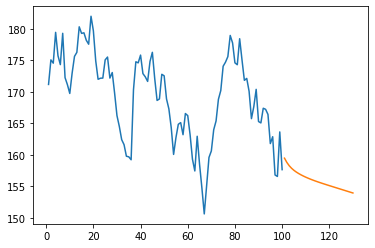

In [44]:
plt.plot(day_new,scaler.inverse_transform(df1[1159:])) ## 1159 because total length of df1 =1259
plt.plot(day_pred,scaler.inverse_transform(lst_output))

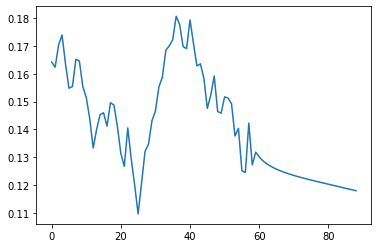

In [45]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

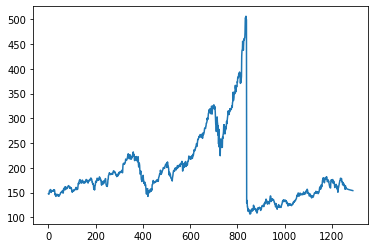

In [46]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)